In [1]:
from transformers import AutoImageProcessor, ViTModel
import torch
from datasets import load_dataset

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

from tqdm.auto import tqdm

import base64
import json

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Meta Settings

In [2]:
# path to where the images are stored
data_dir = "repeat/"

# Patch size of the model
# patch_size = 16
patch_size = 32

# which model to use, base is the pretrained VIT from google
model_type = "base"
# border_width = 2

# Width of the color border
border_width = int(patch_size / 8)

# Adjust the bias term (Out of date, don't use)
adjust_bias_term = False

# Centering the vectors
centering = True

# Scale the Key & Query pairs
scale = False

# Number of images in the dataset
num_images = 8

## Read in the dataset and Initialize VIT Model

In [3]:
dataset = load_dataset("imagefolder", data_dir=data_dir)

image_processor = AutoImageProcessor.from_pretrained(f"google/vit-{model_type}-patch{patch_size}-224-in21k")
model = ViTModel.from_pretrained(f"google/vit-{model_type}-patch{patch_size}-224-in21k")

Using custom data configuration default-2c4ab9019dd17e64


Extracting data files: 0it [00:00, ?it/s]


Dataset imagefolder downloaded and prepared to /n/home10/cyeh/.cache/huggingface/datasets/imagefolder/default-2c4ab9019dd17e64/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 71.00it/s]


## Prepare the color border for patches

In [4]:
pink_border_h = np.ones(shape=(patch_size, border_width, 3)) * np.array([227 / 255, 55 / 255, 143 / 255]).reshape(-1, 3)

pink_border_v = np.ones(shape=(border_width, patch_size + border_width * 2, 3)) * np.array([227 / 255, 55 / 255, 143 / 255]).reshape(-1, 3)

green_border_h = np.ones(shape=(patch_size, border_width, 3)) * np.array([95 / 255, 185 / 255, 108 / 255]).reshape(-1, 3)

green_border_v = np.ones(shape=(border_width, patch_size + border_width * 2, 3)) * np.array([95 / 255, 185 / 255, 108 / 255]).reshape(-1, 3)

pink_border_h = np.repeat(np.expand_dims(pink_border_h, 0), (224 // patch_size) ** 2, axis=0)

pink_border_v = np.repeat(np.expand_dims(pink_border_v, 0), (224 // patch_size) ** 2, axis=0)

green_border_h = np.repeat(np.expand_dims(green_border_h, 0), (224 // patch_size) ** 2, axis=0)

green_border_v = np.repeat(np.expand_dims(green_border_v, 0), (224 // patch_size) ** 2, axis=0)

## Extract the Key/Query from VIT model and Project them to the joint embedding space

In [5]:
from collections import OrderedDict
class ModuleHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.module = None
        self.features = []

    def hook_fn(self, module, input, output):
        self.module = module
        self.features.append(output.detach())

    def close(self):
        self.hook.remove()
        
        
all_patches = None
all_output = {}
all_attentions = {}
vit_embeddeds = {"PCA": {}, "TSNE": {}, "UMAP": {},
                 "PCA_3d": {}, "TSNE_3d": {}, "UMAP_3d": {}}
# for i in range(len(dataset["train"]["image"])):
for i in tqdm(range(num_images)):
    # image = dataset["test"]["image"][i]
    image = dataset["train"]["image"][i]
    inputs = image_processor(image, return_tensors="pt")
    features = OrderedDict()

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) and ("key" in name or "query" in name):
            features[name] = ModuleHook(module)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    for feature in features.values():
        feature.close()
        
    all_attentions[i] = outputs.attentions
        
    np_image = inputs.pixel_values[0].permute([1, 2, 0]).clone().cpu().numpy()

    np_image /= 2
    np_image += 0.5

    image_patches = np_image.reshape(224 // patch_size, patch_size, 
                                     224 // patch_size, patch_size, 3).swapaxes(1, 2).reshape((224 // patch_size) ** 2, 
                                                                                              patch_size,
                                                                                              patch_size, 3)
    if i == 0:
        all_patches = image_patches
    else:
        all_patches = np.concatenate([all_patches, image_patches])
    
    for layer in range(12):
        if i == 0:
            all_output[layer] = {}
        layer_query_name = f"encoder.layer.{layer}.attention.attention.query"
        layer_key_name = f"encoder.layer.{layer}.attention.attention.key"
        
        if adjust_bias_term:
            raw_query_feature = features[layer_query_name].features[0].cpu().detach().numpy()[0, :] - model.encoder.layer[layer].attention.attention.query.bias.clone().cpu().detach().numpy()
            raw_key_feature = features[layer_key_name].features[0].cpu().detach().numpy()[0, :] - model.encoder.layer[layer].attention.attention.key.bias.clone().cpu().detach().numpy()
        else:
            raw_query_feature = features[layer_query_name].features[0].cpu().detach().numpy()[0, :]
            raw_key_feature = features[layer_key_name].features[0].cpu().detach().numpy()[0, :] 
            
        layer_query_feature = np.array(np.split(raw_query_feature,
                                       12, axis=-1))
        layer_key_feature = np.array(np.split(raw_key_feature,
                                     12, axis=-1))
        
        
        for head in range(12):
            if i == 0:
                all_output[layer][head] = np.concatenate([layer_query_feature[head], layer_key_feature[head]])
            else:
                all_output[layer][head] = np.concatenate([all_output[layer][head], 
                                                          np.concatenate([layer_query_feature[head], 
                                                                          layer_key_feature[head]])])
            
    key_image_patches = np.concatenate([pink_border_v, 
                                    np.concatenate([pink_border_h, image_patches, pink_border_h], axis=2),
                                    pink_border_v], axis=1)

    query_image_patches = np.concatenate([green_border_v, 
                                          np.concatenate([green_border_h, image_patches, green_border_h], axis=2),
                                          green_border_v], axis=1)

    filename_prefix = dataset['train']['image'][i].filename
    filename_prefix = filename_prefix[filename_prefix.rfind("/") + 1:filename_prefix.rfind(".")]
    for nth_image in range(image_patches.shape[0]):
        plt.imsave(f"vit{patch_size}_image_patches/{filename_prefix}_patch_{nth_image}.png", image_patches[nth_image])
        plt.imsave(f"vit{patch_size}_image_patches/key_{filename_prefix}_patch_{nth_image}.png", key_image_patches[nth_image])
        plt.imsave(f"vit{patch_size}_image_patches/query_{filename_prefix}_patch_{nth_image}.png", query_image_patches[nth_image])

        
for layer in range(12):
    for head in range(12):
        dataset_size = num_images * ((224 // patch_size) ** 2)
        if centering:
            queries = all_output[layer][head].reshape(-1, (224 // patch_size) ** 2 + 1, 64)[::2].copy().astype("float")
            keys = all_output[layer][head].reshape(-1, (224 // patch_size) ** 2 + 1, 64)[1::2].copy().astype("float")
            queries = queries.reshape(-1, 64)
            keys = keys.reshape(-1, 64)
            mean_shift = np.mean(queries, axis=0) - np.mean(keys, axis=0)
            normalized_embeddings = all_output[layer][head].reshape(-1, (224 // patch_size) ** 2 + 1, 64).copy().astype("float")
            normalized_embeddings[1::2] += mean_shift
            all_output[layer][head] = normalized_embeddings.reshape(-1, 64)
        
        if scale:
            queries = all_output[layer][head].reshape(-1, (224 // patch_size) ** 2 + 1, 64)[::2].copy().astype("float")
            keys = all_output[layer][head].reshape(-1, (224 // patch_size) ** 2 + 1, 64)[1::2].copy().astype("float")
            queries = queries.reshape(-1, 64)
            keys = keys.reshape(-1, 64)
            q_n = np.linalg.norm(queries, axis=1).mean()
            k_n = np.linalg.norm(keys, axis=1).mean()
            
            c = np.sqrt(q_n / k_n) 

            normalized_embeddings = all_output[layer][head].reshape(-1, (224 // patch_size) ** 2 + 1, 64).copy().astype("float")
            normalized_embeddings[1::2] *= c
            normalized_embeddings[::2] *= (1 / c)
            all_output[layer][head] = normalized_embeddingsized_embeddings
        
            
for layer in tqdm(range(12)):
    vit_embeddeds["TSNE"][layer] = {}
    vit_embeddeds["TSNE_3d"][layer] = {}
    vit_embeddeds["PCA"][layer] = {}
    vit_embeddeds["PCA_3d"][layer] = {}
    vit_embeddeds["UMAP"][layer] = {}
    vit_embeddeds["UMAP_3d"][layer] = {}
    for head in tqdm(range(12)):
        vit_embeddeds["TSNE"][layer][head] = TSNE(n_components=2, learning_rate='auto', n_jobs=-1, metric="cosine",
                                                  init='random', perplexity=20).fit_transform(all_output[layer][head])
        vit_embeddeds["TSNE_3d"][layer][head] = TSNE(n_components=3, learning_rate='auto', n_jobs=-1, metric="cosine",
                                                     init='random', perplexity=20).fit_transform(all_output[layer][head])
        
        vit_embeddeds["PCA"][layer][head] = PCA(n_components=2,).fit_transform(all_output[layer][head])
        vit_embeddeds["PCA_3d"][layer][head] = PCA(n_components=3, ).fit_transform(all_output[layer][head])
        
        reducer = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric="cosine",)
        vit_embeddeds["UMAP"][layer][head] = reducer.fit_transform(all_output[layer][head])
        
        reducer = umap.UMAP(n_neighbors=10, n_components=3, min_dist=0.1, metric="cosine",)
        vit_embeddeds["UMAP_3d"][layer][head] = reducer.fit_transform(all_output[layer][head])

100%|██████████| 12/12 [28:40<00:00, 143.35s/it]


## Store the image patches into token file

torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


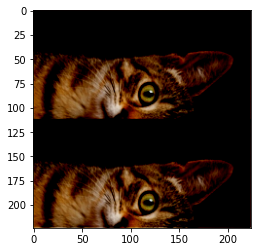

In [6]:
for i in range(num_images):
    image = dataset["train"]["image"][i]
    inputs = image_processor(image, return_tensors="pt")
    
    np_image = inputs.pixel_values[0].permute([1, 2, 0]).clone().cpu().numpy()

    np_image /= 2
    np_image += 0.5
    
    filename_prefix = dataset['train']['image'][i].filename
    filename_prefix = filename_prefix[filename_prefix.rfind("/") + 1:filename_prefix.rfind(".")]
    
    plt.imsave(f"original_images/original_image_{filename_prefix}.png", np_image)

print(inputs.pixel_values.shape)
plt.imshow(inputs.pixel_values[0].permute([1, 2, 0]))

## Annotate Image Patch (Using the Automated Segmentation Model)

<ipython-input-7-41b4f4676530>:28: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = sem_idx_to_class[mode(seg[i: i + patch_size, j: j + patch_size].ravel())[0][0]]


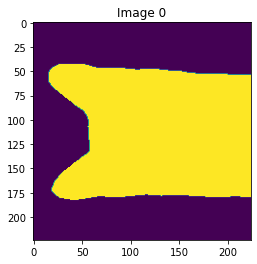

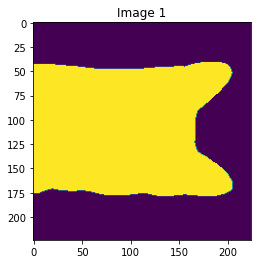

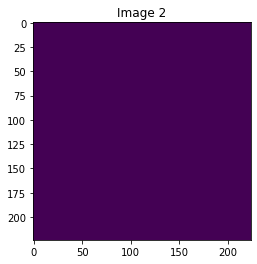

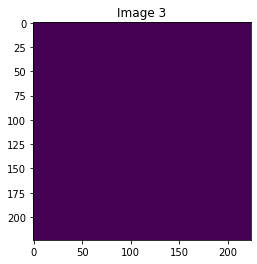

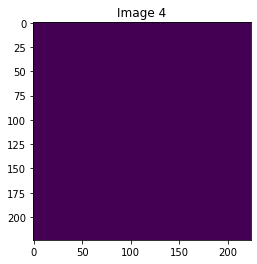

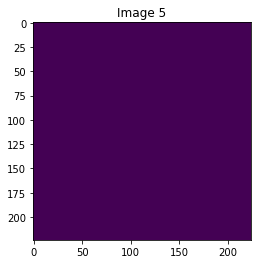

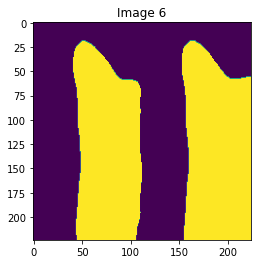

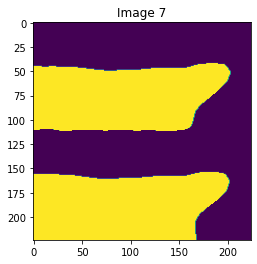

In [7]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from scipy.stats import mode

weights = DeepLabV3_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=[224, 224])

model = deeplabv3_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(dataset["train"]["image"][i]) for i in range(num_images)])
output = model(batch)['out']

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

sem_idx_to_class = {}
for key in list(sem_class_to_idx.keys()):
    sem_idx_to_class[sem_class_to_idx[key]] = key

sem_idx_to_class[0] = "bg"

semantic_labels = {}

for nth_image in range(num_images):
    semantic_labels[nth_image] = ["CLS"]
    seg = torch.argmax(output[nth_image], dim=0).cpu().detach().numpy()
    for i in range(0, 224, patch_size):
        for j in range(0, 224, patch_size):
            label = sem_idx_to_class[mode(seg[i: i + patch_size, j: j + patch_size].ravel())[0][0]]
            semantic_labels[nth_image].append(label)
            
    plt.figure()
    plt.title(f"Image {nth_image:d}")
    plt.imshow(seg)

## Serialize Attention, Token, Embedding data into Pickle File

In [8]:
def convert_image_to_base64(image_path):
    binary_fc = open(filepath, 'rb').read()  # fc aka file_content
    base64_utf8_str = base64.b64encode(binary_fc).decode('utf-8')

    ext     = filepath.split('.')[-1]
    dataurl = f'data:image/{ext};base64,{base64_utf8_str}'
    
    return dataurl


for layer_ind in range(12):
    for head_ind in range(12):
        embedding_json = {}
        embedding_json["layer"] = layer_ind
        embedding_json["head"] = head_ind
        
        embedding_json["tokens"] = []
        for i in range(len(vit_embeddeds["TSNE"][layer_ind][head_ind])):
            embedding_json["tokens"].append({"tsne_x": float(vit_embeddeds["TSNE"][layer_ind][head_ind][i, 0]),
                                             "tsne_y": float(vit_embeddeds["TSNE"][layer_ind][head_ind][i, 1]),
                                             "tsne_x_3d": float(vit_embeddeds["TSNE_3d"][layer_ind][head_ind][i, 0]),
                                             "tsne_y_3d": float(vit_embeddeds["TSNE_3d"][layer_ind][head_ind][i, 1]), 
                                             "tsne_z_3d": float(vit_embeddeds["TSNE_3d"][layer_ind][head_ind][i, 2]),
                                             "pca_x": float(vit_embeddeds["PCA"][layer_ind][head_ind][i, 0]),
                                             "pca_y": float(vit_embeddeds["PCA"][layer_ind][head_ind][i, 1]),
                                             "pca_x_3d": float(vit_embeddeds["PCA_3d"][layer_ind][head_ind][i, 0]),
                                             "pca_y_3d": float(vit_embeddeds["PCA_3d"][layer_ind][head_ind][i, 1]),
                                             "pca_z_3d": float(vit_embeddeds["PCA_3d"][layer_ind][head_ind][i, 2]),
                                             "umap_x": float(vit_embeddeds["UMAP"][layer_ind][head_ind][i, 0]),
                                             "umap_y": float(vit_embeddeds["UMAP"][layer_ind][head_ind][i, 1]),
                                             "umap_x_3d": float(vit_embeddeds["UMAP_3d"][layer_ind][head_ind][i, 0]),
                                             "umap_y_3d": float(vit_embeddeds["UMAP_3d"][layer_ind][head_ind][i, 1]),
                                             "umap_z_3d": float(vit_embeddeds["UMAP_3d"][layer_ind][head_ind][i, 2]),})
            
        json_object = json.dumps(embedding_json)
        
        with open(f"vit{patch_size}_layer/layer{layer_ind}_head{head_ind}.json", "w") as outfile:
            outfile.write(json_object)
            
        attention_json = {}
        attention_json["layer"] = layer_ind
        attention_json["head"] = head_ind
        
        attention_json["tokens"] = []
        for i in range(num_images):
            sel_attention = all_attentions[i][layer_ind][0][head_ind].clone()
            for j in range(len(sel_attention)):
                attention_json["tokens"].append({"attention": sel_attention[j].cpu().detach().tolist()})
            for j in range(sel_attention.shape[1]):
                attention_json["tokens"].append({"attention": sel_attention[:, j].cpu().detach().tolist()})
        
        json_object = json.dumps(attention_json)
        
        with open(f"vit{patch_size}_attention/layer{layer_ind}_head{head_ind}.json", "w") as outfile:
            outfile.write(json_object)
            
            
token_json = {"tokens": []}
for nth_data in range(num_images):
    filename_prefix = dataset['train']['image'][nth_data].filename
    filename_prefix = filename_prefix[filename_prefix.rfind("/") + 1:filename_prefix.rfind(".")]
    for i in range((224 // patch_size) ** 2 + 1):
        if i == 0:
            dataurl = "https://raw.githubusercontent.com/catherinesyeh/attention-viz/VIT-vis/img/cls_query_image.png"
            original_patch_dataurl = "https://raw.githubusercontent.com/catherinesyeh/attention-viz/VIT-vis/img/cls_query_image.png"
        
            filepath = f"original_images/original_image_{filename_prefix}.png"

            binary_fc = open(filepath, 'rb').read()  # fc aka file_content
            base64_utf8_str = base64.b64encode(binary_fc).decode('utf-8')

            ext     = filepath.split('.')[-1]
            original_image_dataurl = f'data:image/{ext};base64,{base64_utf8_str}'
        else:
            filepath = f"vit{patch_size}_image_patches/query_{filename_prefix}_patch_{i - 1}.png"

            binary_fc = open(filepath, 'rb').read()  # fc aka file_content
            base64_utf8_str = base64.b64encode(binary_fc).decode('utf-8')

            ext     = filepath.split('.')[-1]
            dataurl = f'data:image/{ext};base64,{base64_utf8_str}'
        
            filepath = f"vit{patch_size}_image_patches/{filename_prefix}_patch_{i - 1}.png"

            binary_fc = open(filepath, 'rb').read()  # fc aka file_content
            base64_utf8_str = base64.b64encode(binary_fc).decode('utf-8')

            ext     = filepath.split('.')[-1]
            original_patch_dataurl = f'data:image/{ext};base64,{base64_utf8_str}'
    
            original_image_dataurl = "null"
            
        if i == 0:
            row = 0
            col = 0
            ad_row = 0
            ad_col = -1
        else:
            row = (i - 1) // (224 // patch_size)
            col = (i - 1) % (224 // patch_size)
            ad_row = row
            ad_col = col
        
        token_json["tokens"].append({"originalImagePath": original_image_dataurl,
                                     "originalPatchPath": original_patch_dataurl,
                                     "imagePath": dataurl,
                                     "position": row,
                                     "pos_int": col,
                                     "position_row": ad_row,
                                     "position_col": ad_col,
                                     "type": "query",
                                     "value": f"{semantic_labels[nth_data][i % ((224 // patch_size) ** 2 + 1)]}",})

    for i in range((224 // patch_size) ** 2 + 1):
        if i == 0:
            dataurl = "https://raw.githubusercontent.com/catherinesyeh/attention-viz/VIT-vis/img/cls_key_image.png"
            original_patch_dataurl = "https://raw.githubusercontent.com/catherinesyeh/attention-viz/VIT-vis/img/cls_key_image.png"
            
            filepath = f"original_images/original_image_{filename_prefix}.png"

            binary_fc = open(filepath, 'rb').read()  # fc aka file_content
            base64_utf8_str = base64.b64encode(binary_fc).decode('utf-8')

            ext     = filepath.split('.')[-1]
            original_image_dataurl = f'data:image/{ext};base64,{base64_utf8_str}'
        else:
            filepath = f"vit{patch_size}_image_patches/key_{filename_prefix}_patch_{i - 1}.png"

            binary_fc = open(filepath, 'rb').read()  # fc aka file_content
            base64_utf8_str = base64.b64encode(binary_fc).decode('utf-8')

            ext     = filepath.split('.')[-1]
            dataurl = f'data:image/{ext};base64,{base64_utf8_str}'
        
            filepath = f"vit{patch_size}_image_patches/{filename_prefix}_patch_{i - 1}.png"

            binary_fc = open(filepath, 'rb').read()  # fc aka file_content
            base64_utf8_str = base64.b64encode(binary_fc).decode('utf-8')

            ext     = filepath.split('.')[-1]
            original_patch_dataurl = f'data:image/{ext};base64,{base64_utf8_str}'

            original_image_dataurl = "null"
            
        if i == 0:
            row = 0
            col = 0
            ad_row = 0
            ad_col = -1
        else:
            row = (i - 1) // (224 // patch_size)
            col = (i - 1) % (224 // patch_size)
            ad_row = row
            ad_col = col
        
        token_json["tokens"].append({"originalImagePath": original_image_dataurl,
                                     "originalPatchPath": original_patch_dataurl,
                                     "imagePath": dataurl,
                                     "position": row, 
                                     "pos_int": col,
                                     "position_row": ad_row,
                                     "position_col": ad_col,
                                     "type": "key",
                                     "value": f"{semantic_labels[nth_data][i % ((224 // patch_size) ** 2 + 1)]}",})


json_object = json.dumps(token_json)
with open(f"tokens_{patch_size}.json", "w") as outfile:
    outfile.write(json_object)